In [308]:
#working with classification on pytorch
import torch
from torch import nn
import matplotlib.pyplot as plt

In [309]:
#making a toy classification dataset
import sklearn
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [310]:
len(X), len(y)

(1000, 1000)

In [311]:
print(X[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]


In [312]:
print(y[:5])

[1 1 1 1 0]


In [313]:
import pandas as pd

df = pd.DataFrame({'X1:': X[:, 0],
                   'X2': X[:, 1],
                   'label': y})

In [314]:
df.head()

,X1:,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


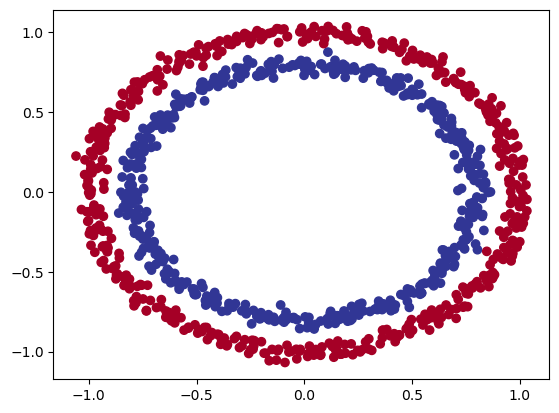

In [315]:
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.show()

In [316]:
#turning data into tensors

X.shape, y.shape

((1000, 2), (1000,))

In [317]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [318]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [319]:
type(X), type(y)

(torch.Tensor, torch.Tensor)

In [320]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [321]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [322]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [323]:
#setting up device agnostic code

device = 'mps' if torch.mps.is_available() else 'cpu'
device

'mps'

In [324]:
#creating a model
class ClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.two_linear_layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=8),
            nn.Linear(in_features=8, out_features=1)
        )

    def forward(self, x):
        return self.two_linear_layers(x)

model = ClassificationModel().to(device)
model


ClassificationModel(
  (two_linear_layers): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [325]:
next(model.parameters()).device

device(type='mps', index=0)

In [326]:
model.state_dict()

OrderedDict([('two_linear_layers.0.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998]], device='mps:0')),
             ('two_linear_layers.0.bias',
              tensor([ 0.5451,  0.1045, -0.3301,  0.1802, -0.3258, -0.0829, -0.2872,  0.4691],
                     device='mps:0')),
             ('two_linear_layers.1.weight',
              tensor([[-0.2791, -0.1630, -0.0998, -0.2126,  0.0334, -0.3492,  0.3193, -0.3003]],
                     device='mps:0')),
             ('two_linear_layers.1.bias', tensor([0.2730], device='mps:0'))])

In [327]:
#make predictions
with torch.inference_mode():
    untrained_preds = model(X_test.to(device))
print(f'Length: {len(untrained_preds)}, Shape: {untrained_preds.shape}')
print(f'Length: {len(X_test)}, Shape: {X_test.shape}')
print(f'First 10 predictions: {torch.round(untrained_preds[:10])}')
print(f'First 10 labels: {y_test[:10]}')

Length: 200, Shape: torch.Size([200, 1])
Length: 200, Shape: torch.Size([200, 2])
First 10 predictions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='mps:0')
First 10 labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [328]:
#setting up a loss function and optimizers
loss_fn = nn.BCEWithLogitsLoss()
loss_fn

BCEWithLogitsLoss()

In [329]:
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [330]:
#calculate accuracy
def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [331]:
#training our model
#going from raw logits to prediction probabilities
model.eval()
with torch.inference_mode():
    y_logits = model(X_test.to(device))[:5]
y_logits

tensor([[-0.3104],
        [-0.4788],
        [ 0.1177],
        [-0.4316],
        [ 0.0967]], device='mps:0')

In [332]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [333]:
y_pred_prob = torch.sigmoid(y_logits)
y_pred_prob

tensor([[0.4230],
        [0.3825],
        [0.5294],
        [0.3937],
        [0.5242]], device='mps:0')

In [334]:
y_preds = torch.round(y_pred_prob)
y_pred_labels = torch.round(torch.sigmoid(model(X_test.to(device))[:5]))
print(torch.eq(y_preds.squeeze(),y_pred_labels.squeeze()))
y_preds.squeeze()

tensor([True, True, True, True, True], device='mps:0')


tensor([0., 0., 1., 0., 1.], device='mps:0')

In [335]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model.train()
    y_logits_1 = model(X_train).squeeze()
    y_pred_1 = torch.round(torch.sigmoid(y_logits_1))
    loss = loss_fn(y_logits_1, y_train)
    acc = accuracy(y_true=y_train, y_pred=y_pred_1)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model.eval()
    with torch.inference_mode():
        y_logits_test = model(X_test).squeeze()
        y_pred_test = torch.round(torch.sigmoid(y_logits_test))
        test_loss = loss_fn(y_logits_test, y_test)
        test_acc = accuracy(y_true=y_test, y_pred=y_pred_test)

    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f} | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}')

Epoch: 0 | Loss: 0.70544, Accuracy: 48.25 | Test Loss: 0.69489, Test Accuracy: 53.00
Epoch: 10 | Loss: 0.70482, Accuracy: 48.25 | Test Loss: 0.69443, Test Accuracy: 53.50
Epoch: 20 | Loss: 0.70425, Accuracy: 48.38 | Test Loss: 0.69402, Test Accuracy: 54.00
Epoch: 30 | Loss: 0.70372, Accuracy: 48.25 | Test Loss: 0.69365, Test Accuracy: 53.50
Epoch: 40 | Loss: 0.70323, Accuracy: 48.00 | Test Loss: 0.69331, Test Accuracy: 53.00
Epoch: 50 | Loss: 0.70278, Accuracy: 48.00 | Test Loss: 0.69301, Test Accuracy: 53.00
Epoch: 60 | Loss: 0.70236, Accuracy: 47.88 | Test Loss: 0.69274, Test Accuracy: 53.00
Epoch: 70 | Loss: 0.70196, Accuracy: 48.25 | Test Loss: 0.69250, Test Accuracy: 52.00
Epoch: 80 | Loss: 0.70159, Accuracy: 48.25 | Test Loss: 0.69228, Test Accuracy: 52.50
Epoch: 90 | Loss: 0.70125, Accuracy: 48.25 | Test Loss: 0.69209, Test Accuracy: 52.50
Epoch: 100 | Loss: 0.70092, Accuracy: 48.50 | Test Loss: 0.69191, Test Accuracy: 53.00
Epoch: 110 | Loss: 0.70062, Accuracy: 48.62 | Test Los

In [336]:
#getting visual

import requests
from pathlib import Path
if Path('helper_functions.py').is_file():
    print('helper_functions.py already exists')
else:
    print('Downloading')
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    with open('helper_functions.py', 'wb') as f:
        f.write(request.content)
from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists


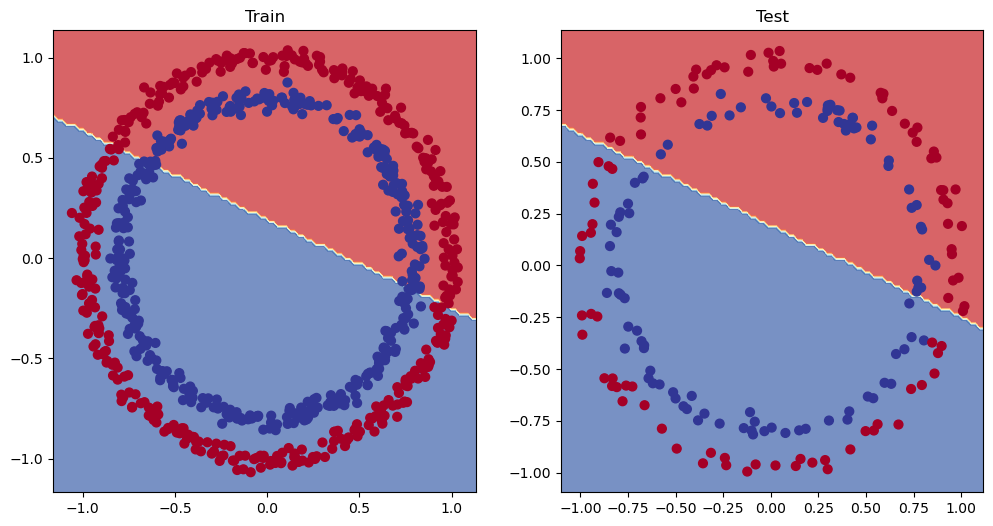

In [337]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model, X_test, y_test)

In [338]:
#improving a model

#add more layers/hidden units/fit for longer/changing the activation functions/change the lr/change loss function

model.state_dict()

OrderedDict([('two_linear_layers.0.weight',
              tensor([[ 0.5234,  0.5478],
                      [-0.1751,  0.6280],
                      [-0.1644,  0.1213],
                      [-0.3615,  0.3760],
                      [ 0.6234, -0.5186],
                      [ 0.5852,  0.0654],
                      [ 0.5557,  0.1715],
                      [ 0.3137, -0.1619]])),
             ('two_linear_layers.0.bias',
              tensor([ 0.5405,  0.1016, -0.3313,  0.1775, -0.3249, -0.0874, -0.2846,  0.4659])),
             ('two_linear_layers.1.weight',
              tensor([[-0.1016, -0.0410, -0.0901, -0.1591, -0.0225, -0.2724,  0.3957, -0.2926]])),
             ('two_linear_layers.1.bias', tensor([0.2835]))])

In [339]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=16)
        self.layer2 = nn.Linear(in_features=16, out_features=24)
        self.layer3 = nn.Linear(in_features=24, out_features=1)
    
    def forward(self, x):
        # z = self.layer1(x)
        # z = self.layer2(z)
        # z = self.layer3(z)
        return self.layer3(self.layer2(self.layer1(x)))

model_0 = CircleModel().to(device)
model_0

CircleModel(
  (layer1): Linear(in_features=2, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=24, bias=True)
  (layer3): Linear(in_features=24, out_features=1, bias=True)
)

In [340]:
#create a loss function

criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.1)

In [341]:
torch.manual_seed(42)
torch.mps.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
    model_0.train()
    y_logits_0 = model_0(X_train).squeeze()
    y_preds_0 = torch.round(torch.sigmoid(y_logits_0))
    loss = criterion(y_logits_0, y_train)
    acc = accuracy(y_train, y_preds_0)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        y_logits_test_0 = model_0(X_test).squeeze()
        y_preds_test_0 = torch.round(torch.sigmoid(y_logits_test_0))
        test_loss_0 = criterion(y_logits_test_0, y_test)
        acc = accuracy(y_test, y_preds_test_0)
        
    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f} | Loss Test: {test_loss:.5f} | Accuracy Test: {test_acc:.2f}')

Epoch: 0 | Loss: 0.69413 | Accuracy: 45.50 | Loss Test: 0.69217 | Accuracy Test: 54.50
Epoch: 100 | Loss: 0.69298 | Accuracy: 45.50 | Loss Test: 0.69217 | Accuracy Test: 54.50
Epoch: 200 | Loss: 0.69298 | Accuracy: 46.00 | Loss Test: 0.69217 | Accuracy Test: 54.50
Epoch: 300 | Loss: 0.69298 | Accuracy: 46.00 | Loss Test: 0.69217 | Accuracy Test: 54.50
Epoch: 400 | Loss: 0.69298 | Accuracy: 46.00 | Loss Test: 0.69217 | Accuracy Test: 54.50
Epoch: 500 | Loss: 0.69298 | Accuracy: 46.00 | Loss Test: 0.69217 | Accuracy Test: 54.50
Epoch: 600 | Loss: 0.69298 | Accuracy: 46.00 | Loss Test: 0.69217 | Accuracy Test: 54.50
Epoch: 700 | Loss: 0.69298 | Accuracy: 46.00 | Loss Test: 0.69217 | Accuracy Test: 54.50
Epoch: 800 | Loss: 0.69298 | Accuracy: 46.00 | Loss Test: 0.69217 | Accuracy Test: 54.50
Epoch: 900 | Loss: 0.69298 | Accuracy: 46.00 | Loss Test: 0.69217 | Accuracy Test: 54.50


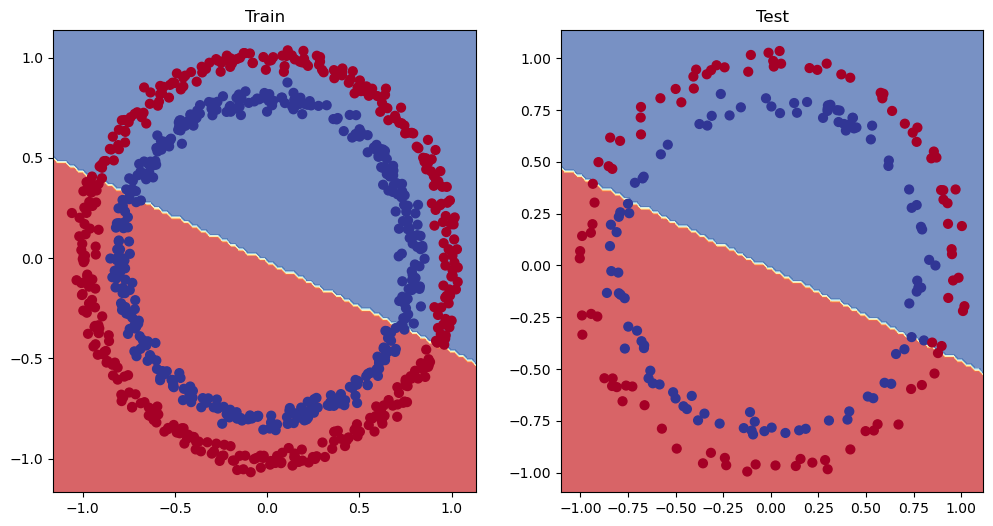

In [342]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)

In [343]:
#troubleshooting

weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

print(len(X_regression))

100


In [344]:
X_regression[:5]

tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400]])

In [345]:
y_regression[:5]

tensor([[0.3000],
        [0.3070],
        [0.3140],
        [0.3210],
        [0.3280]])

In [346]:
train_split = int(0.8*len(X_regression))
X_train_reg, y_train_reg =  X_regression[:train_split], y_regression[:train_split]
X_test_reg, y_test_reg =  X_regression[train_split:], y_regression[train_split:]

len(X_train_reg), len(y_train_reg), len(X_test_reg), len(y_test_reg)

(80, 80, 20, 20)

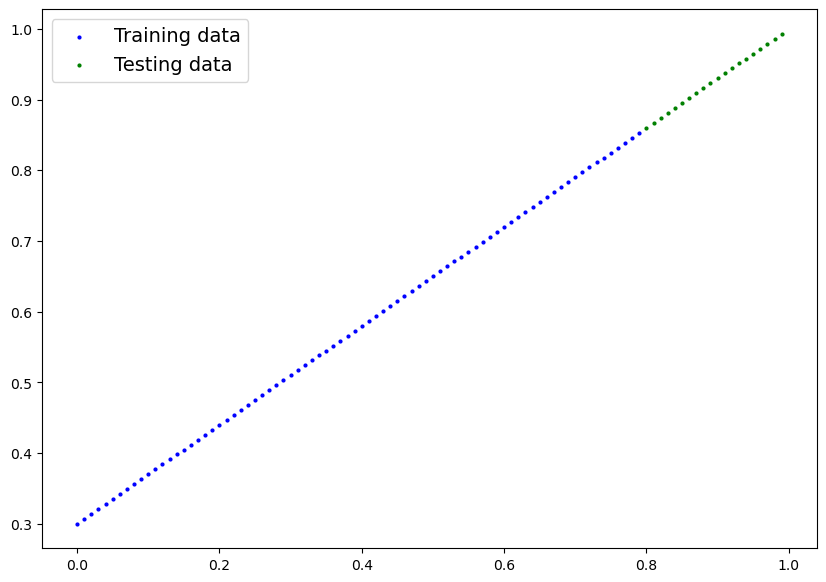

In [347]:
plot_predictions(train_data=X_train_reg, train_labels=y_train_reg, test_data=X_test_reg, test_labels=y_test_reg)

In [348]:
model_0

CircleModel(
  (layer1): Linear(in_features=2, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=24, bias=True)
  (layer3): Linear(in_features=24, out_features=1, bias=True)
)

In [349]:
model_1 = nn.Sequential(
    nn.Linear(in_features=1, out_features=16),
    nn.Linear(in_features=16, out_features=24),
    nn.Linear(in_features=24, out_features=1)
).to(device)

model_1

Sequential(
  (0): Linear(in_features=1, out_features=16, bias=True)
  (1): Linear(in_features=16, out_features=24, bias=True)
  (2): Linear(in_features=24, out_features=1, bias=True)
)

In [350]:
loss_fn = nn.L1Loss()
loss_fn

L1Loss()

In [351]:
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.1)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    weight_decay: 0
)

In [352]:
torch.manual_seed(42)
torch.mps.manual_seed(42)

epochs = 1000

X_train_reg = X_train_reg.to(device)
y_train_reg = y_train_reg.to(device)
X_test_reg = X_test_reg.to(device)
y_test_reg = y_test_reg.to(device)

for epoch in range(epochs):
    model_1.train()
    y_pred_reg = model_1(X_train_reg)
    loss = loss_fn(y_pred_reg, y_train_reg)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        y_pred_reg_test = model_1(X_test_reg)
        test_loss = loss_fn(y_pred_reg_test, y_test_reg)
    
    if epoch % 100 == 0:
        print(f'Epochs: {epoch} | Loss: {loss} | Test Loss: {test_loss}')


Epochs: 0 | Loss: 0.44772741198539734 | Test Loss: 3.609675645828247
Epochs: 100 | Loss: 0.03514966368675232 | Test Loss: 0.06411751359701157
Epochs: 200 | Loss: 0.03817210718989372 | Test Loss: 0.036482568830251694
Epochs: 300 | Loss: 0.023859787732362747 | Test Loss: 0.09309529513120651
Epochs: 400 | Loss: 0.008150101639330387 | Test Loss: 0.0482579730451107
Epochs: 500 | Loss: 0.022588307037949562 | Test Loss: 0.005254385061562061
Epochs: 600 | Loss: 0.019121212884783745 | Test Loss: 0.02271786890923977
Epochs: 700 | Loss: 0.014349480159580708 | Test Loss: 0.0169427040964365
Epochs: 800 | Loss: 0.02011880651116371 | Test Loss: 0.0030227096285670996
Epochs: 900 | Loss: 0.0035224370658397675 | Test Loss: 0.008165222592651844


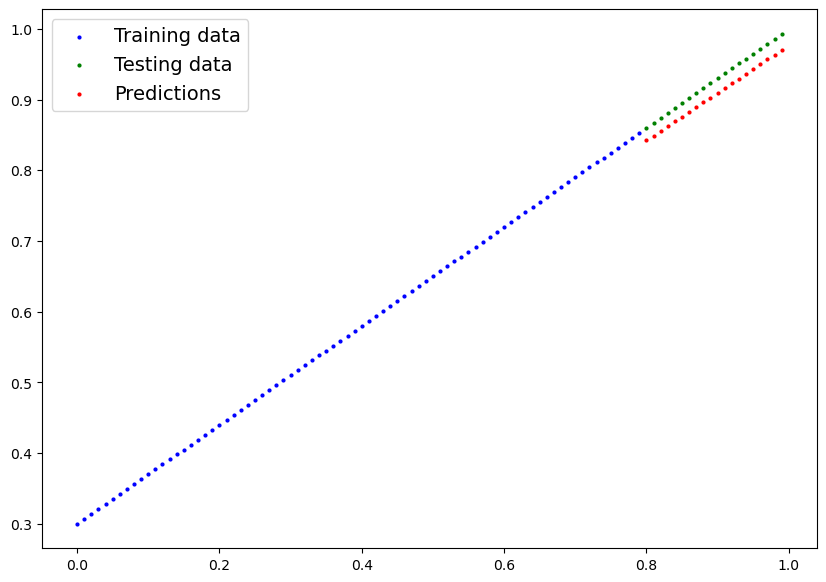

In [353]:
model_1.eval()

with torch.inference_mode():
    y_preds_reg_1 = model_1(X_test_reg)

plot_predictions(train_data=X_train_reg.cpu(), train_labels=y_train_reg.cpu(), test_data=X_test_reg.cpu(), test_labels=y_test_reg.cpu(), predictions=y_preds_reg_1.cpu())

In [354]:
#the missing piece is non-linearity

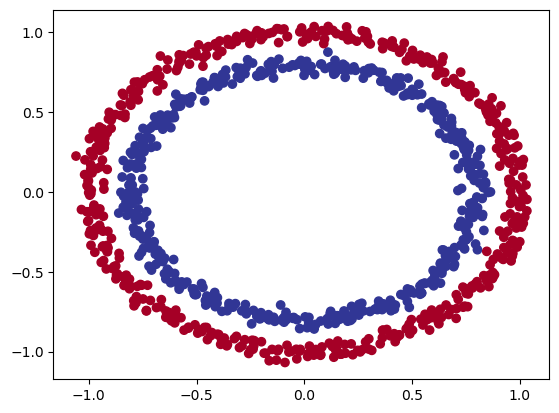

In [355]:
import sklearn
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.show()

In [356]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=16)
        self.layer_2 = nn.Linear(in_features=16, out_features=24)
        self.layer_3 = nn.Linear(in_features=24, out_features=1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_2 = CircleModelV1().to(device)
model_2

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=24, bias=True)
  (layer_3): Linear(in_features=24, out_features=1, bias=True)
  (relu): ReLU()
)

In [357]:
loss_fnct = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.1)

In [358]:
torch.manual_seed(42)
torch.mps.manual_seed(42)

epochs = 1000

for epoch in range(epochs):
    model.train()
    y_logits_2 = model_2(X_train).squeeze()
    y_pred_2 = torch.round(torch.sigmoid(y_logits_2))
    loss = loss_fnct(y_logits_2, y_train)
    acc = accuracy(y_true=y_train, y_pred=y_pred_2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.inference_mode():
        y_test_logits = model_2(X_test).squeeze()
        y_pred_2_test = torch.round(torch.sigmoid(y_test_logits))
        test_loss_2 = loss_fnct(y_test_logits, y_test)
        test_acc = accuracy(y_true=y_test, y_pred=(y_pred_2_test))
    
    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss_2} | Accuracy: {acc} | Test Accuracy: {test_acc}')

Epoch: 0 | Loss: 0.6947094202041626 | Test Loss: 0.7438623309135437 | Accuracy: 50.0 | Test Accuracy: 50.0
Epoch: 100 | Loss: 0.006405563559383154 | Test Loss: 0.016443531960248947 | Accuracy: 100.0 | Test Accuracy: 99.5
Epoch: 200 | Loss: 0.002490396611392498 | Test Loss: 0.00859330128878355 | Accuracy: 100.0 | Test Accuracy: 99.5
Epoch: 300 | Loss: 0.0013965463731437922 | Test Loss: 0.005808519199490547 | Accuracy: 100.0 | Test Accuracy: 100.0
Epoch: 400 | Loss: 0.0009108560625463724 | Test Loss: 0.0043518091551959515 | Accuracy: 100.0 | Test Accuracy: 100.0
Epoch: 500 | Loss: 0.0006469262298196554 | Test Loss: 0.0037728091701865196 | Accuracy: 100.0 | Test Accuracy: 100.0
Epoch: 600 | Loss: 0.0004856932209804654 | Test Loss: 0.003420502645894885 | Accuracy: 100.0 | Test Accuracy: 100.0
Epoch: 700 | Loss: 0.0003503727784845978 | Test Loss: 0.0032401438802480698 | Accuracy: 100.0 | Test Accuracy: 100.0
Epoch: 800 | Loss: 0.0002811139856930822 | Test Loss: 0.0027471096254885197 | Accur

In [362]:
model_2.eval()

with torch.inference_mode():
    y_predicted = torch.round(torch.sigmoid(model_2(X_test))).squeeze()

y_predicted[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='mps:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='mps:0'))

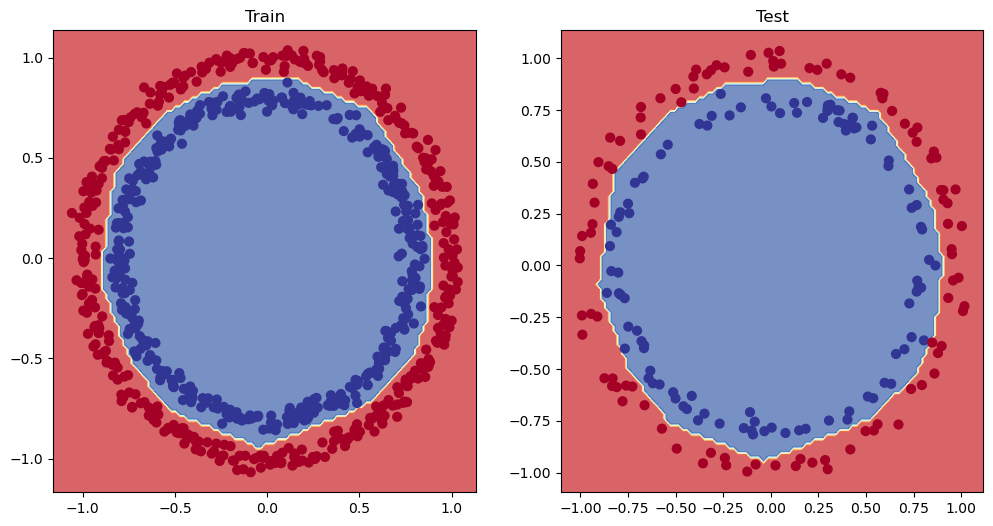

In [363]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_2, X_test, y_test)

In [364]:
#replicating non linear activations

In [365]:
A = torch.arange(-10,10,1,dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

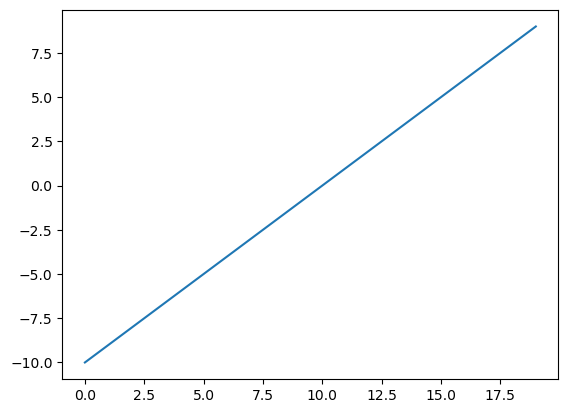

In [366]:
plt.plot(A)

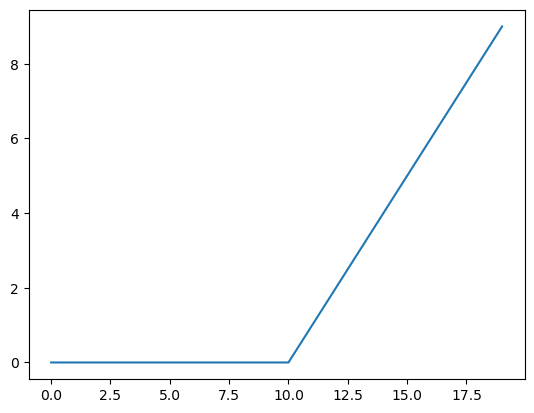

In [367]:
plt.plot(torch.relu(A))

In [368]:
def relu(x):
    return torch.maximum(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

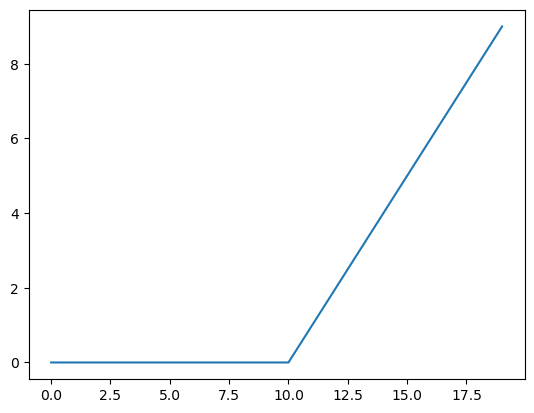

In [369]:
plt.plot(relu(A))

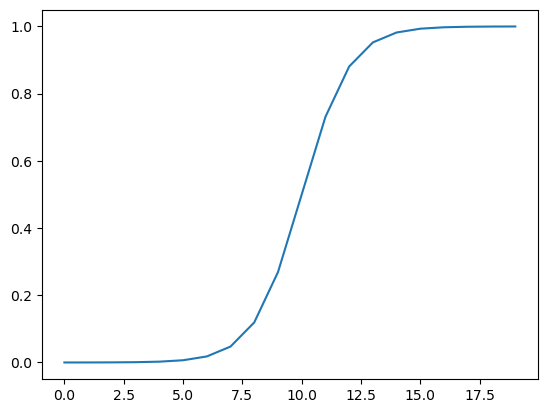

In [370]:
plt.plot(torch.sigmoid(A))

In [371]:
def sigmoid(x):
    return 1/(1+torch.exp(-x))

sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

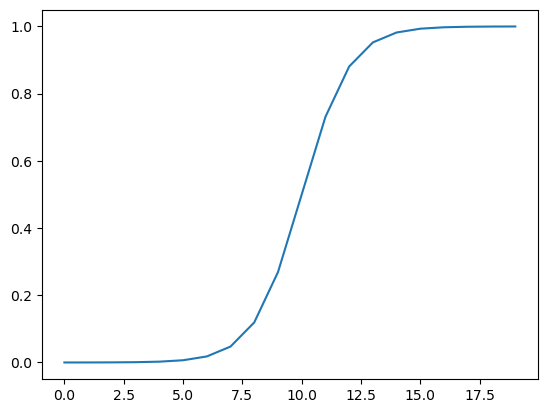

In [372]:
plt.plot(sigmoid(A))